# A simple example of the analysis in Dessert et al. _Science_ 2020

This notebook contains a pedagogical treatment of an example analysis of the stacked data from the MOS camera onboard XMM-Newton presented in [Dessert et al. _Science_ 2020](https://science.sciencemag.org/content/367/6485/1465). These example analyses can be performed using the data products produced in that reference. In order to make the notebook relatively short and self-contained, we make two simplification on the dataset we treat.

Firstly, we restrict ourselves to data collected by the MOS data. The reason is that the MOS camera has a simpler instrument response (in particular the PN camera has a variable energy binning). Nevertheless, keep in mind that the data here is only half the story: the PN data produces comparable limits as the MOS data (see the paper).

Secondly, we work with the stacked dataset produced by combining the various MOS exposures. For the main result in Dessert et al. _Science_ 2020, we instead use a joint likelihood approach. The joint likelihood has a variety of advantages relative to stacking the data, as described in the paper. Still, comparable sensitivity is achieved by stacking the data, and as it's the simpler of the two approaches we pursue it here.  However, we _strongly_ recommend the joint likelihood approach for scientific applications.  It is more sensitive than the stacked data approach and also less subject to systematic uncertainties.

Finally, if you use the data in this example in a publication, please cite Dessert et al. _Science_ 2020.

**Please direct any questions to bsafdi@umich.edu.**

In [1]:
# Import required modules

%matplotlib inline
%load_ext autoreload
%autoreload 2
 
import sys,os
import numpy as np
from scipy.optimize import minimize
from scipy.stats import chi2 as chi2_scipy

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rcParams['text.usetex'] = True
rcParams['text.latex.unicode'] = True

**NB**: In this notebook, we minimize with `scipy` so that it is easy to run for the interested reader. For scientific analysis, we recommend [Minuit](https://iminuit.readthedocs.io/en/latest/) as a minimizer. In our paper, we used Minuit.

# Define signal line energy

By default we will look for an anomalous line at 3.55 keV, as defined by the EUXL parameter below, denoting the energy of the unidentified X-ray line. Lines at different energies can be searched for by changing this parameter accordingly (for example to 3.5 keV). We start with 3.55 keV as this is within the best energy range suggested by [Bulbul et al. _Astrophys. J._ 2014](https://iopscience.iop.org/article/10.1088/0004-637X/789/1/13).

In [2]:
EUXL = 3.55 # [keV]

**NB:** changing EUXL will of course vary the results below, and values in the surrounding discussion will not necessarily be reflective.

# Load in the data and models

First we will load in the data products that we will use in the analysis.  These include the stacked MOS data, associated energy bins, and uncertainties. 

We will use data from two regions of interest (ROI):
- **Signal Region (SR)**: 5-45 degrees from the Galactic Center, this was the fiducial ROI in our main analysis;
- **Background Region (BR)**: 60-90 degrees from the Galactic Center, a useful region for studying background as it contains less dark matter.

We also load the appropriately averaged D-factors for these two regions (ROIs) for our fiducial NFW profile, along with the respective exposure times.

In [3]:
## Signal Region (5-45 degrees)

# Data and associated errors
data = np.load("../data/data_mos_sig_ROI.npy") # [cts/s/keV]
data_yerrs = np.load("../data/data_errors_mos_sig_ROI.npy") # [cts/s/keV]

# Exposure time
Exp = 23.27726013638801e6 # [s]

# D-factor averaged over the signal ROI
D_signal = 5.2e28 # [keV/cm^2]


## Background Region (60-90 degrees)

# Data and associated errors
data_bkg = np.load("../data/data_mos_back_ROI.npy") # [cts/s/keV]
data_yerrs_bkg = np.load("../data/data_errors_mos_back_ROI.npy") # [cts/s/keV]

# Exposure time
Exp_bkg = 67.63917495602036e6 # [s]

# D-factor averaged over the background ROI
D_bkg = 1.2e28 # [keV/cm^2]


## Energy binning appropriate for both the signal and background
Energies = np.load("../data/Energies.npy") # [keV}

## Plot of the data

Data in the signal region, where the dashed vertical line denotes the location of a putative signal line.

/sw/lsa/centos7/python-anaconda2/2019.03/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


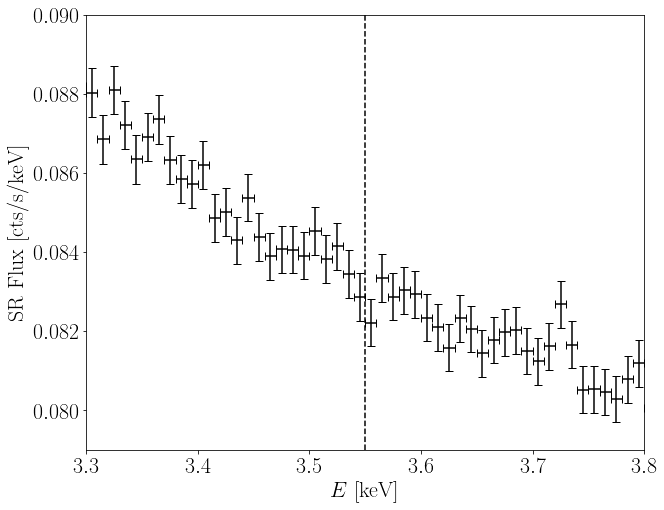

In [4]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,
             color="black",label="data",marker="o", fmt='none',capsize=4)
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(3.3,3.8)
plt.ylim(7.9e-2,9e-2)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.show()

In several examples we will take our signal data and subtract off data from a region well away from the Galactic Center. This background region is the 60-90 degree data loaded above, and will be referred to as the "background" region. One reason for doing this is to check for the possibility that there are instrumental or other background that do not vary as a function of distance from the Galactic Center as the Dark Matter flux will. 

Below, we show the difference between the two datasets.

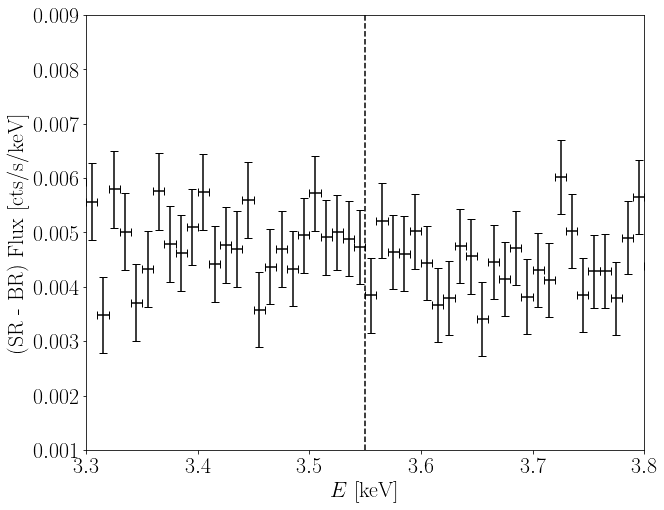

In [5]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data-data_bkg,yerr=np.sqrt(data_yerrs**2+data_yerrs_bkg**2),
             xerr=(Energies[1]-Energies[0])/2.,color="black",label="data",marker="o", fmt='none',capsize=4)
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(3.3,3.8)
plt.ylim(1e-3,9e-3)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"(SR - BR) Flux [cts/s/keV]",fontsize=22)
plt.show()

## Load in the Models

Next we use the models that will be used in fitting the above data.

There are a sequence of models corresponding to physical line fluxes at the energies specified by `Es_line`.  That is, `mod_UXL` gives the detectors counts as a function of energy after forward modeling a physical line at EUXL keV with a flux of 1 cts/cm$^2$/s/sr.

In [6]:
# Firstly import 100 precomputed line shapes accounting for the XMM-Newton MOS instrument response
# between 3 and 4 keV
Es_line = np.load("../data/Es_line.npy") # Energies of precomputed lines
mods = np.load("../data/mods.npy") # Model for the lines, all normalized to 1 cts/cm^2/s/sr at the relevant energy

# Extract the closest model to describe a line at E=EUXL
arg_UXL = np.argmin((Es_line-EUXL)**2)
mod_UXL = mods[arg_UXL]
print "The energy of our "+str(EUXL)+" keV line example will be: "+str(Es_line[arg_UXL])+" keV"

The energy of our 3.55 keV line example will be: 3.5525876460767947 keV


### Aside: what flux do we need to simply over-produce the observed data?

Suppose that we simply wanted to simply not over-produce the data, without any background modelling assumptions.  This leads to a limit of $\sin^2(2\theta) \lesssim 10^{-10}$, as shown below.

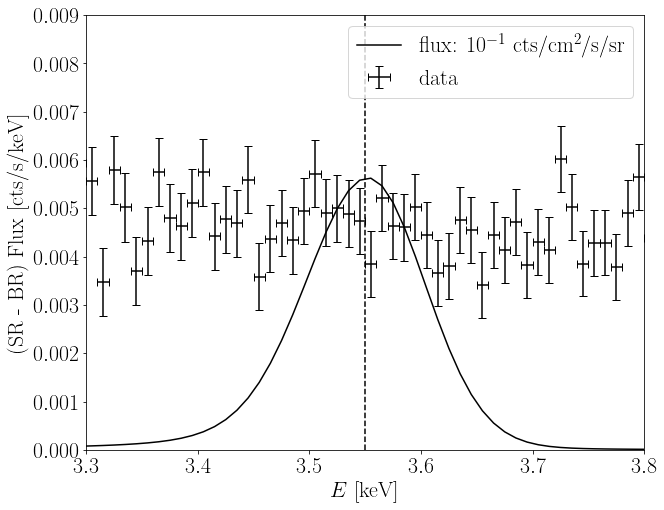

In [7]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data-data_bkg,yerr=np.sqrt(data_yerrs**2+data_yerrs_bkg**2),
             xerr=(Energies[1]-Energies[0])/2.,color="black",label="data",marker="o", fmt='none',capsize=4)
plt.plot(Energies,1.e-1*mod_UXL,'k-',label =r"flux: $10^{-1}$ cts/cm$^2$/s/sr")
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(3.3,3.8)
plt.ylim(0,9e-3)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"(SR - BR) Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

This plot demonstrates that, regardless of the background modeling, a dark matter signal line with flux brighter than $\sim 10^{-1}$ cts/cm$^2$/s/sr in the signal region versus the background region will overproduce the observed data.  Of course, we will do better than this by modeling the continum emission and also using a statistical analysis, but let's use this example for what value of $\sin^2(2\theta)$ is associated with this flux.

In [8]:
def return_sin_theta_lim(E_line,flux,D_factor):
    """
    D_factor [keV/cm^2]
    flux [cts/cm^2/s/sr]
    E_line [keV] (dark matter mass is twice this value)
    returns: associated sin^2(2theta)
    """
    DMmass = 2.*E_line
    res = (4.*np.pi*DMmass/D_factor)/1.361e-22*(1/DMmass)**5*flux
    return res

In [9]:
print 'The "by eye" limit from the plot above is sin^2(2theta) < '+str(return_sin_theta_lim(EUXL,1.e-1,D_signal-D_bkg))+'.'

The "by eye" limit from the plot above is sin^2(2theta) < 9.08360734099e-11.


This simple exercise demonstrates, that independent of other sources of flux, a value of $\sin^2(2\theta) \lesssim 10^{-10}$ larger than the limit obtained above would simply overproduce the observed data. Interestingly, looking at Fig. 1 of Dessert et al. 2020, this is already a relevant constraint. We will now improve upon this limit by modeling the continuum.

# Statistical analysis

Now, let's perform a rigorous statistical analysis, using profile likelihood. As we operate in the large counts limit for the stacked data, we can perform a simple $\chi^2$ analysis rather than a full joint likelihood analysis as used by default in Dessert et al. 2020.

**NB:** we will model the background over this narrow region as a simple featureless polynomial. In particular, we choose a quadratic function as used for the stacked analysis in Dessert et al. 2020. Nevertheless, similar results are obtained for a simple power law or most other smooth functions. Users are encouraged to try alternative models.

In [10]:
## Define the functions we will use

class chi2:
    """ A set offunctions for calculation the chisq associated with different hypotheses
    """
    def __init__(self,ens,dat,err,null_mod,sig_template):
        self._ens = ens
        self._dat = dat
        self._err = err
        self._null_mod = null_mod
        self._sig_template = sig_template
        self._A_sig = 0.0
    
    def chi2(self,x):
        null_mod = self._null_mod(self._ens,x[1:])
        sig_mod = self._sig_template*x[0]
        return np.sum((self._dat - null_mod - sig_mod)**2/self._err**2)
    
    def chi2_null(self,x):
        null_mod = self._null_mod(self._ens,x)
        return np.sum((self._dat - null_mod)**2/self._err**2)
    
    def chi2_fixed_signal(self,x):
        null_mod = self._null_mod(self._ens,x)
        sig_mod = self._sig_template*self._A_sig
        return np.sum((self._dat - null_mod - sig_mod)**2/self._err**2) 
    
    def fix_signal_strength(self,A_sig):
        self._A_sig = A_sig
        

def mod_poly(ens,x):
    """ A simple polynomial model for the background
    """
    A, B, C = x
    return A+B*ens + C*ens**2

## Fit within $E_{\rm UXL} \pm 0.25$ keV

First, we will fit the models from $[E_{\rm UXL}-0.25,\,E_{\rm UXL}+0.25]$ keV. Later in this notebook, we broaden this range to 3.0 to 4.0 keV. For the default $E_{\rm UXL} = 3.55$ keV, this correspond to $3.3~{\rm keV} < E < 3.8~{\rm keV}$.

To begin with then, let's reduce the dataset to this restricted range.

In [11]:
whs_reduced = np.where((Energies >= EUXL-0.25) & (Energies <= EUXL+0.25))[0]
Energies_reduced = Energies[whs_reduced]
data_reduced = data[whs_reduced]
data_yerrs_reduced = data_yerrs[whs_reduced]
data_bkg_reduced = data_bkg[whs_reduced]
data_yerrs_bkg_reduced = data_yerrs_bkg[whs_reduced]
mod_UXL_reduced = mod_UXL[whs_reduced]

Next, let's fit this data with the background only hypothesis and consider the quality of fit.

In [12]:
# Compute the best fit parameters by minimising the chisq

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_poly,mod_UXL_reduced)

mn_null = minimize(chi2_instance.chi2_null,np.array([0.3,-0.1,0.01]),method='Nelder-Mead')

print "Best fit background parameters:",mn_null.x
print "The chi^2/DOF of the null-model fit is :", mn_null.fun/(len(whs_reduced)-3.)

print "Expected 68% containment for the chi^2/DOF:", np.array(chi2_scipy.interval(0.68,len(whs_reduced)-3.))/float(len(whs_reduced)-3.)
print "Expected 95% containment for the chi^2/DOF:", np.array(chi2_scipy.interval(0.95,len(whs_reduced)-3.))/float(len(whs_reduced)-3.)

Best fit background parameters: [ 0.37612592 -0.15075261  0.01921897]
The chi^2/DOF of the null-model fit is : 0.6799248225595458
Expected 68% containment for the chi^2/DOF: [0.79617522 1.20353891]
Expected 95% containment for the chi^2/DOF: [0.63736587 1.44299249]


So, in this example the null model is a really good fit! It is actually such a good fit that the $\chi^2 / {\rm DOF}$ is outside of the 68\% expectation, though it is within the 95\% expectation.

Next, let's see how much a line at EUXL can improve upon this fit.

In [13]:
# Compute the best fit parameters by minimising the chisq

mn = minimize(chi2_instance.chi2,np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2]]),method='Nelder-Mead')

print "Best fit signal+background parameters:", mn.x
print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun

Best fit signal+background parameters: [ 0.00041136  0.37774868 -0.1516748   0.01934939]
The Delta chi^2 between signal and null model is: 0.007432370724785642


The $\Delta \chi^2$ between the signal and null models, which are nested with the signal model having one additional DOF, is small (~0.01). As such setting a limit rather than claiming a discovery for a line at this energy is appropriate. We will turn to the question of limit setting in the next section.

To help visualise these results, below we plot the best fit background.

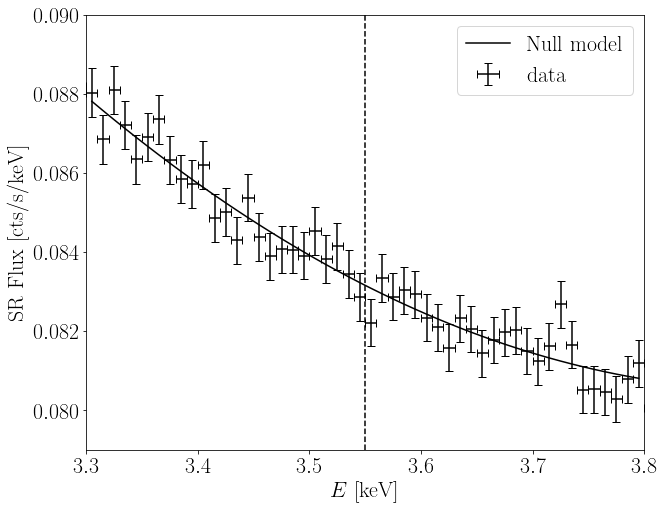

In [14]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,color="black",
             label="data",marker="o", fmt='none',capsize=4)
plt.plot(Energies_reduced,mod_poly(Energies_reduced,mn_null.x),'k-',label =r"Null model")
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(EUXL-0.25,EUXL+0.25)
plt.ylim(7.9e-2,9e-2)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

## Profile likelihood

Now, let's construct the profile likelihood to get an approximate 95\% upper limit. The qualifier approximate applies as we are going to assume Wilks' theorem and simply look for values of the signal parameter for which the profile likelihood rises above ~2.71 from the minimum.  To be completely rigorous, the actual limit should be constructed from MC simulations.

In order to determine where this occurs, we calculate the likelihood at several fixed values of the signal flux, starting at the best fit value determined above. In each case we refloat the background as required by the profile likelihood.

In [15]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',
                          options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun
    
amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.011931952410827977 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 8.337320808568518e-12


So, we see that modeling the background and using a statistical analysis gives us an improved limit relative to simply not overshooting the data (by a factor ~10 - 20).  Below, we plot the profile likelihood.

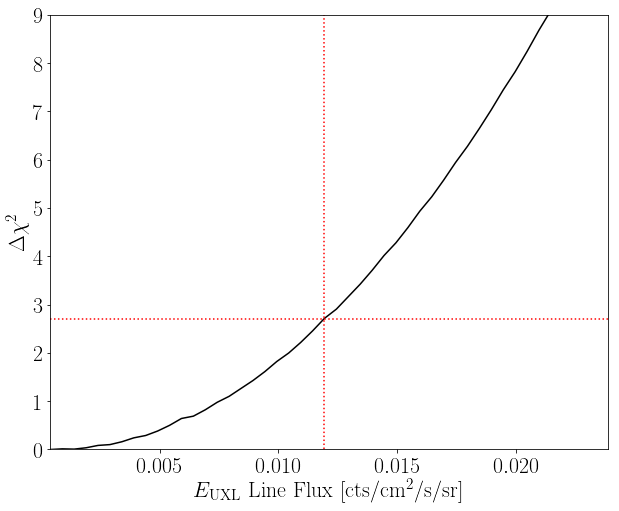

In [16]:
fig = plt.figure(figsize=(10,8))
plt.plot(A_sig_array,chi2_sig_array-chi2_sig_array[0],'k-')
plt.axhline(2.71,color="red",linestyle="dotted")
plt.axvline(limit_signal_strength,color="red",linestyle="dotted")
plt.xlim(mn.x[0],limit_signal_strength*2.)
plt.ylim(0,9)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E_{\rm UXL}$ Line Flux [cts/cm$^2$/s/sr]",fontsize=22)
plt.ylabel(r"$\Delta \chi^2$",fontsize=22)
plt.show()

## Fitting to the Signal Region - Background Region data

Continuing, let's perform a fit of the signal region - background region data, which recall we considered earlier for the "limit by eye". We don't expect to get a stronger limit, since we are actually only increasing the statistical uncertainties in this analysis, but we might reduce the systematics associated with e.g. unmodeled instrumental lines that would be common to both datasets.

The analysis procedes in direct analogy to that above, simple with a new dataset.

In [17]:
chi2_smb_instance = chi2(Energies_reduced,data_reduced-data_bkg_reduced,
                         np.sqrt(data_yerrs_reduced**2+data_yerrs_bkg_reduced**2),mod_poly,mod_UXL_reduced)

mn_null = minimize(chi2_smb_instance.chi2_null,np.array([0.005,-0.001,0.001]),method='Nelder-Mead')

mn = minimize(chi2_smb_instance.chi2,np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2]]),method='Nelder-Mead')

print "Best fit signal+background parameters:", mn.x
print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun
print "The chi^2/DOF of the null-model fit is :", mn_null.fun/(len(whs_reduced)-3.)

print "Expected 68% containment for the chi^2/DOF:", np.array(chi2_scipy.interval(0.68,len(whs_reduced)-3.))/float(len(whs_reduced)-3.)
print "Expected 95% containment for the chi^2/DOF:", np.array(chi2_scipy.interval(0.95,len(whs_reduced)-3.))/float(len(whs_reduced)-3.)

Best fit signal+background parameters: [ 1.42094417e-03  7.61604863e-03 -7.52637007e-04 -2.61669489e-05]
The Delta chi^2 between signal and null model is: 0.07338694747547692
The chi^2/DOF of the null-model fit is : 0.9183029704107314
Expected 68% containment for the chi^2/DOF: [0.79617522 1.20353891]
Expected 95% containment for the chi^2/DOF: [0.63736587 1.44299249]


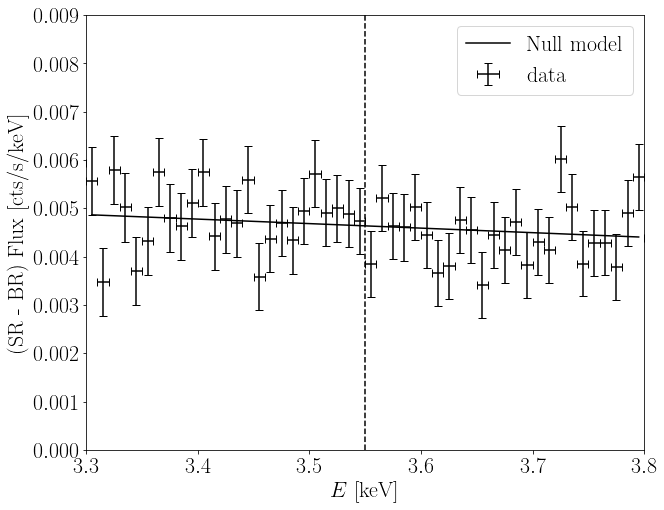

In [18]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data-data_bkg,yerr=np.sqrt(data_yerrs**2 + data_yerrs_bkg**2),
             xerr=(Energies[1]-Energies[0])/2.,color="black",label="data",marker="o", fmt='none',capsize=4)
plt.plot(Energies_reduced,mod_poly(Energies_reduced,mn_null.x),'k-',label =r"Null model")
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(EUXL-0.25,EUXL+0.25)
plt.ylim(0,9e-3)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"(SR - BR) Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

Again the best-fit signal strength is positive ($\sim 1 \times 10^{-3}$ cts/cm$^2$/s), though only at the level $\Delta \chi^2 \sim 0.1$, which is negligable significance.  The null model again is a good description of the data, and in particular the $\chi^2 / {\rm DOF}$ is within the 68\% expectation.

Let's again compute the limit using the profile likelihood technique.

In [19]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_smb_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_smb_instance.chi2_fixed_signal,bf,method='Nelder-Mead',
                          options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal-D_bkg)

The 95% upper limit on the signal flux is 0.023993030717331807 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 2.1794326995665512e-11


This analysis gives a slightly weaker limit (flux $\sim 2 \times 10^{-2}$ cts/cm$^2$/s/sr as opposed to $\sim 1 \times 10^{-2}$ cts/cm$^2$/s/sr from the fit to the signal only data).  This is likely mostly related to the increased statistical uncertainties obtained by subtracting the background region data. An additional consideration is that the translation from flux limits to limits on $\sin^2(2\theta)$ is affected by the fact that some signal would appear in the bkg region, which is why we subtracted the D-factor from the background region.

Regardless, this limit, although weaker, still strongly constrains the DM interpretation of the 3.55 keV line (see Dessert et al. 2020 Fig. 1).

## Extending the background model to include additional lines

Let's now suppose that the background model contains additional degrees of freedom beyond those considered above. In particular, we consider the possibility that there are lines at 3.3 keV and 3.7 keV, as has been suggested in, for example, [Boyarsky et al. 2018](https://arxiv.org/pdf/1812.10488.pdf). Evidence for instrumental lines at these energies in the PN camera has been presented in the detailed detector study of [Struder et al. _Nucl. Instrum. Methods Phys. Res._ 2003](https://ui.adsabs.harvard.edu/abs/2003NIMPA.512..386S/abstract). However, as we are only considering the MOS camera here, no instrumental lines at these energies exist. However, plasma emission lines exist at these energies, and in principle those lines could appear in our data at a low level.

Regardless, we can always include these extra lines in our analysis and test whether evidence for a 3.5 keV line appear in this case. Note that ahead of time we expect a weaker limit to result from this analysis, as there will be an enhanced degeneracy between the signal and background models.

In [20]:
arg_3p3 = np.argmin((Es_line-3.32)**2) 
mod_3p3 = mods[arg_3p3]

arg_3p7 = np.argmin((Es_line-3.68)**2)
mod_3p7 = mods[arg_3p7]

def mod_poly_two_lines(ens,x):
    "An extended background model to include two additional lines"
    A, B, C, S1, S2 = x
    return A+B*ens + C*ens**2 + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_poly_two_lines,mod_UXL_reduced)

mn_null = minimize(chi2_instance.chi2_null,np.array([0.3667,-0.1453, 0.01845,1.e-3,1e-4]),method='Nelder-Mead')

mn = minimize(chi2_instance.chi2,np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4]]),method='Nelder-Mead',options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})

print "Best fit signal+background parameters:", mn.x
print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun
print "The chi^2/DOF of the null-model fit is:", mn_null.fun/(len(whs_reduced)-5.)

print "Expected 68% containment for the chi^2/DOF:", np.array(chi2_scipy.interval(0.68,len(whs_reduced)-5.))/float(len(whs_reduced)-5.)
print "Expected 95% containment for the chi^2/DOF:", np.array(chi2_scipy.interval(0.95,len(whs_reduced)-5.))/float(len(whs_reduced)-5.)

Best fit signal+background parameters: [ 3.90646744e-04  3.67552205e-01 -1.46038257e-01  1.85707388e-02
  1.33855913e-03  1.51259684e-04]
The Delta chi^2 between signal and null model is: 0.06701429668256509
The chi^2/DOF of the null-model fit is: 0.7061536991813123
Expected 68% containment for the chi^2/DOF: [0.79175881 1.20794392]
Expected 95% containment for the chi^2/DOF: [0.63035894 1.45355909]


The inclusion of additional lines has not changed our conclusion. The null model is still a good fit to the data, and the best-fit signal strength is still consistent with zero at 1$\sigma$.

Next we plot the best fit signal and background model, in particular we see the model is almost identical in the two cases, emphasizing the lack of preference for a new emission line at 3.55 keV in this dataset.

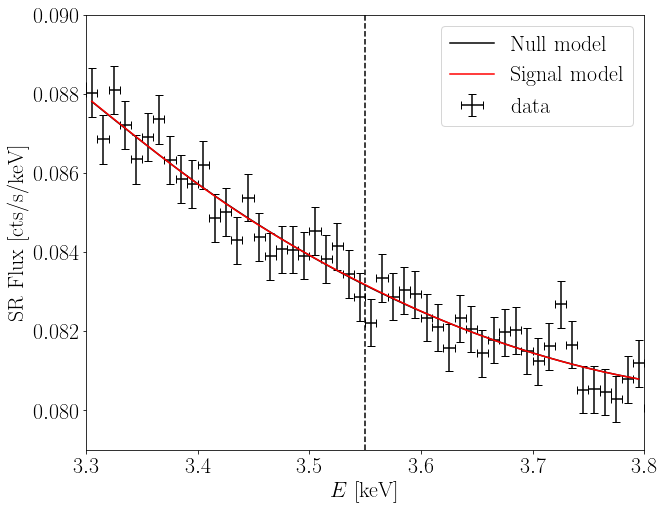

In [21]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,
             color="black",label="data",marker="o", fmt='none',capsize=4)
plt.plot(Energies_reduced,mod_poly_two_lines(Energies_reduced,mn_null.x),
         'k-',label =r"Null model")
plt.plot(Energies_reduced,mod_poly_two_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_UXL_reduced,
         'r-',label =r"Signal model")
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(EUXL-0.25,EUXL+0.25)
plt.ylim(7.9e-2,9e-2)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

Finally let's compute the associated limit via profile likelihood.

In [22]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',
                          options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(3.55,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.023942561926367994 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 1.6729602405889626e-11


Note that including the background lines made the limit on $\sin^2(2\theta)$ ever so slightly weaker (it went from $8 \times 10^{-12}$ to $1.7 \times 10^{-11}$).  This is because there is now more degeneracy between the signal and backround model, so the effect of a positive signal strength can be partially removed by the appropriate combination of nuisance parameters.  Note that this limit is consistent with that at $m_s = 7.1$ keV in Fig. S14 of Dessert et al. 2020, though again we stress that that plot was constructed from the joint likelihood. 

# Is there something special about $[E_{\rm UXL}-0.25,\,E_{\rm UXL}+0.25]$ keV?

No.  We used a narrow energy range to mitigate possible systematic issues due to imperfections in the null model, but this doesn't mean that we find qualitatively different results if we were to use a wider energy range.  Let's explore the energy range from 3.0 to 4.0 keV.

As pointed out in e.g. [Boyarsky et al. 2018](https://arxiv.org/pdf/1812.10488.pdf), there is a large astrophysical line at ~3.1 keV and also at ~3.9 keV.  We will include both of these lines, in addition to the 3.3 and 3.7 keV lines included above.

Our procedure is as follows. Firstly, we update the dataset. Then we will define a new background model incorporating these additional lines. Finally we repeat our default $\chi^2$ fit procedure.

In [23]:
whs_reduced = np.where((Energies >= 3.0) & (Energies <= 4.0))[0]
Energies_reduced = Energies[whs_reduced]
data_reduced = data[whs_reduced]
data_yerrs_reduced = data_yerrs[whs_reduced]
data_bkg_reduced = data_bkg[whs_reduced]
data_yerrs_bkg_reduced = data_yerrs_bkg[whs_reduced]
mod_UXL_reduced = mod_UXL[whs_reduced]

arg_3p1 = np.argmin((Es_line-3.12)**2)
mod_3p1 = mods[arg_3p1]

arg_3p9 = np.argmin((Es_line-3.90)**2)
mod_3p9 = mods[arg_3p9]

def mod_poly_four_lines(ens,x):
    A, B, C,S1, S2, S3, S4 = x
    return A+B*ens + C*ens**2 + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]+ S3*mod_3p1[whs_reduced] + S4*mod_3p9[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_poly_four_lines,mod_UXL_reduced)

mn_null = minimize(chi2_instance.chi2_null,np.array([0.3667,-0.1453, 0.01845,1.e-2,1.e-2,1.e-2,1.e-2]),method='Nelder-Mead')

mn = minimize(chi2_instance.chi2,np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4],mn_null.x[5],mn_null.x[6]]),method='Nelder-Mead',options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})

print "Best fit background parameters:", mn_null.x
print "Best fit signal+background parameters:", mn.x

print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun
print "The chi^2/DOF of the null-model fit is:", mn_null.fun/(len(whs_reduced)-5.)

print "Expected 68% containment for the chi^2/DOF:", np.array(chi2_scipy.interval(0.68,len(whs_reduced)-5.))/float(len(whs_reduced)-5.)
print "Expected 95% containment for the chi^2/DOF:", np.array(chi2_scipy.interval(0.95,len(whs_reduced)-5.))/float(len(whs_reduced)-5.)

print "NB: the best-fit signal strength in this case is:", mn.x[0], "cts/cm$^2$/s/sr"

Best fit background parameters: [ 0.17072674 -0.03623247  0.0032445   0.02226226  0.00928248  0.07465649
  0.0224222 ]
Best fit signal+background parameters: [ 0.00240164  0.17130311 -0.03634574  0.00323187  0.02064426  0.00857451
  0.07025764  0.02343647]
The Delta chi^2 between signal and null model is: 1.2352644119875578
The chi^2/DOF of the null-model fit is: 0.7973774441762472
Expected 68% containment for the chi^2/DOF: [0.85614219 1.14370943]
Expected 95% containment for the chi^2/DOF: [0.73605123 1.30376807]
NB: the best-fit signal strength in this case is: 0.0024016402904774633 cts/cm$^2$/s/sr


Let's have a look at the best fit signal and background models in this case. There are subtle difference between the two, but no clear excess is appearing at 3.55 keV.

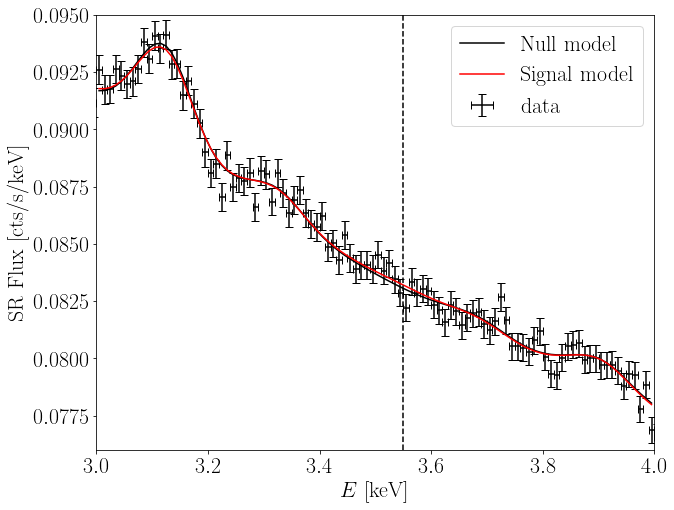

In [24]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,
             color="black",label="data",marker="o", fmt='none',capsize=4)
plt.plot(Energies_reduced,mod_poly_four_lines(Energies_reduced,mn_null.x),
         'k-',label =r"Null model")
plt.plot(Energies_reduced,mod_poly_four_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_UXL_reduced,
         'r-',label =r"Signal model")
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(3.0,4.0)
plt.ylim(7.6e-2,9.5e-2)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

Finally, we compute the limit in this case using the by now familiar procedure.

In [25]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',
                          options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(3.5,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.010094304485955854 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 7.465048537510121e-12


Note that the 95\% upper limit in this case is stronger than it was in the smaller energy range! That is, the limit went from $\sin^2(2\theta) < 1.7 \times 10^{-11}$ to $\sin^2(2\theta) < 7.5 \times 10^{-12}$ when increasing the energy range.  This is _precisely_ what you would expect.  Going to a larger energy range better constrains the null model component, which in turn makes the limit and detection capabilities for the signal component stronger.  On the other hand, going to a larger energy range opens one up more to systematic uncertainties, since it is less clear that the null model can describe the data over the full energy range in this case.  This is why we use a narrower energy range and quote the weaker but more conservative limits.

## Mode at fixed signal strength

As a final illustration, let's fix the signal at its 95\% upper limit and consider the associated model.

In [26]:
A_sig = 0.01 # [cts/cm^2/s/sr]
chi2_instance.fix_signal_strength(A_sig)
mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',
                      options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})

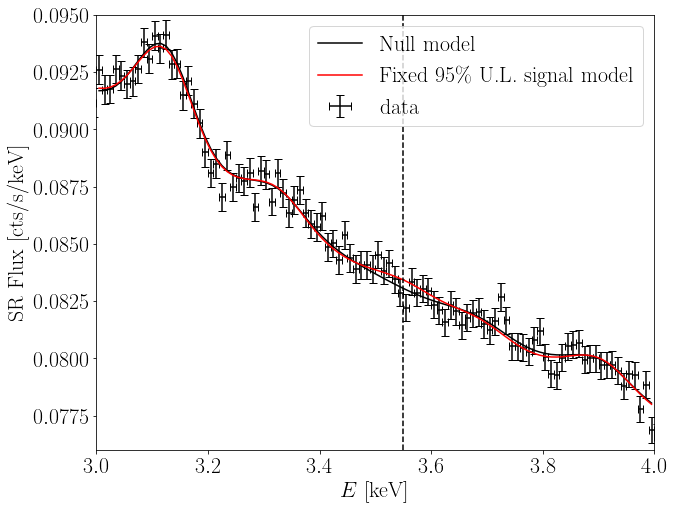

In [27]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,
             color="black",label="data",marker="o", fmt='none',capsize=4)
plt.plot(Energies_reduced,mod_poly_four_lines(Energies_reduced,mn_null.x),
         'k-',label =r"Null model")
plt.plot(Energies_reduced,mod_poly_four_lines(Energies_reduced,mn_profile.x)+A_sig*mod_UXL_reduced,
         'r-',label =r"Fixed 95\% U.L. signal model")
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(3.0,4.0)
plt.ylim(7.6e-2,9.5e-2)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()